## 機器學習期末專題 : Sensor Drift 
dataset: https://archive.ics.uci.edu/ml/datasets/Gas+Sensor+Array+Drift+Dataset+at+Different+Concentrations

這個資料集包含由16個化學感測器對6種不同氣體(丙酮、乙醛、乙醇、乙烯、阿摩尼亞、甲苯)於不同濃度下，從2008/1至2011/2，歷經36個月所取得的13910樣本。每個樣本有128特徵(16x8)。這個問題是根據此128特徵，判斷氣體是那6種氣體裡的哪一種氣體。此資料集的樣本依照收集的時間順序安排，並分成10個資料檔，batch1.dat、...、batch10.dat。由於感測器會因老化、污染，產生感測器飄移(sensor drift)問題，因此根據batch1.dat所學習的分類器，應用在batch2.dat、...、batch10.dat可能會有越來越不準的趨勢。**這個專題的主要目的是分類器設計以及藉由訓練結果可視化該問題，並不是要著手處理感測器飄移問題，但是該專題可應用於確認是否發生了該問題。**



### Open the data set

將檔案載入colab後即可執行

原始檔案為文字檔，用分號區隔，並且第一格數字0-5代表class屬於哪種氣體


In [ ]:
try:
    import pandas as pd
except:
    !pip install pandas
    import pandas as pd

try:
    import sklearn
except:
    !pip install scikit-learn
    import sklearn
    
import numpy as np
from zipfile import ZipFile
import matplotlib.pyplot as plt
%matplotlib inline
dataset = []

with ZipFile('driftdataset.zip') as myzip:
    for idx in range(1,11):
        with myzip.open('batch{}.dat'.format(idx),mode='r') as myfile:
            label_list = []
            level_list = []
            feature    = [list() for _ in range(128)]
            for aline in myfile:
                label, data = aline.decode('ascii').strip().split(';')
                label_list.append(int(label)-1)
                
                data = data.split(' ')
                level_list.append(float(data[0]))

                for i in range(1,len(data)):
                    v= data[i].split(':')
                    feature[int(v[0])-1].append(float(v[1]))
            d = { 'label':label_list,'level':level_list}                       
            d.update({ 'f'+str(idx):feature[idx] for idx in range(128) })    
            dataset.append(pd.DataFrame(d))

### Examine the data set
There are 10 data sets: batch1.dat,...,batch10.dat, which are stored in dataset[0],...,dataset[9], respectively. Each example has the following attributes:
+ label: the class label;
+ level: levels of concentrations (表示濃度);
+ f0~f127: 128 description features from 16 sensors.

In [ ]:
dataset[0].head()

,label,level,f0,f1,f2,f3,f4,f5,f6,f7,...,f118,f119,f120,f121,f122,f123,f124,f125,f126,f127
0,0,10.0,15596.1621,1.868245,2.371604,2.803678,7.512213,-2.739388,-3.344671,-4.847512,...,-1.071137,-3.037772,3037.0390,3.972203,0.527291,0.728443,1.445783,-0.545079,-0.902241,-2.654529
1,0,20.0,26402.0704,2.532401,5.411209,6.509906,7.658469,-4.722217,-5.817651,-7.518333,...,-1.530519,-1.994993,4176.4453,4.281373,0.980205,1.628050,1.951172,-0.889333,-1.323505,-1.749225
2,0,30.0,42103.5820,3.454189,8.198175,10.508439,11.611003,-7.668313,-9.478675,-12.230939,...,-2.384784,-2.867291,5914.6685,5.396827,1.403973,2.476956,3.039841,-1.334558,-1.993659,-2.348370
3,0,40.0,42825.9883,3.451192,12.113940,16.266853,39.910056,-7.849409,-9.689894,-11.921704,...,-2.607199,-3.058086,6147.4744,5.501071,1.981933,3.569823,4.049197,-1.432205,-2.146158,-2.488957
4,0,50.0,58151.1757,4.194839,11.455096,15.715298,17.654915,-11.083364,-13.580692,-16.407848,...,-3.594763,-4.181920,8158.6449,7.174334,1.993808,3.829303,4.402448,-1.930107,-2.931265,-4.088756


In [ ]:
dataset[0].describe()

,label,level,f0,f1,f2,f3,f4,f5,f6,f7,...,f118,f119,f120,f121,f122,f123,f124,f125,f126,f127
count,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,...,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000
mean,2.256180,198.044944,125598.154467,6.105952,27.857710,38.144605,44.128000,-22.588372,-29.794852,-68.791987,...,-7.937931,-9.546743,16178.656558,9.408597,4.673120,8.052993,9.121342,-3.986980,-6.526546,-8.006173
std,1.778751,224.189979,154508.292267,4.888478,34.411330,46.167415,56.617419,28.699951,40.442581,121.644048,...,6.947474,8.616719,10203.134157,5.721681,3.367555,6.750219,7.448286,3.242606,5.511495,7.121117
min,0.000000,5.000000,-518.410100,0.975693,0.237609,0.385293,1.691446,-131.332873,-227.627758,-802.153878,...,-32.451273,-71.867195,114.563200,1.026784,0.151100,0.212589,0.751308,-16.316526,-26.465044,-60.043362
25%,1.000000,50.000000,13925.168000,1.644067,3.469116,4.744795,5.876002,-26.454306,-32.915759,-69.818965,...,-12.147438,-13.189142,8212.465700,5.225894,1.974975,2.916926,3.325322,-5.903510,-9.852850,-11.171626
50%,2.000000,125.000000,73888.513600,4.937347,14.722279,19.372862,21.541595,-11.516816,-14.361441,-22.475106,...,-5.480641,-6.818436,14378.066900,7.082021,3.839486,6.037789,6.782874,-2.866766,-4.586299,-5.843878
75%,4.000000,250.000000,163294.027300,9.785838,37.921243,55.857809,60.098814,-3.031027,-3.760867,-5.109815,...,-2.716342,-3.859406,22025.415100,13.353138,6.962171,11.293738,13.172462,-1.562399,-2.399658,-3.443906
max,5.000000,1000.000000,670687.347700,25.289719,167.079751,226.619457,393.564132,-0.029429,22.201589,115.273147,...,9.270956,11.516418,55483.907000,28.312023,17.103240,37.555263,42.039307,-0.016275,6.851792,8.357968


在 scikit-learn 中，Pipeline 類可用於組裝一系列轉換和最終估計器（分類器）作為單個分類器，組裝後的分類器可以在設置不同超參數的同時進行交叉驗證一個常用的分類器。

為此，準備了5種模型的Pipeline來做5-fold測試，執行時間上可能會略久(約30分左右)

In [ ]:
from scipy import stats
from sklearn import neighbors, svm, datasets
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest,mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
import sklearn as sk
import matplotlib.pyplot as plt
from joblib import parallel_backend

%matplotlib inline

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)

# defining dictionaries: pipeline_knn_param0, pipeline_rbf_svm_param0, pipeline_linear_svm_param, linear_svm_param0
pipeline_knn_param0= {'knn__n_neighbors':[3,5,7]}
pipeline_rbf_svm_param0 = {'svc__C':[0.01, 0.1, 1, 10, 100],'svc__gamma':[0.001,0.01,0.1,1]}
pipeline_linear_svm_param = {'svc__C':[0.01, 0.1, 1, 10, 100],'fr__k':[50,75]}
linear_svm_param0 = {'C':[0.01, 0.1, 1, 10, 100]}

# defining classifiers: knn, svm_rbf, svm_linear, svm_linear0, dt
svm_linear0 = GridSearchCV(estimator=svm.SVC(kernel='linear', gamma=1, C=1, probability=True,decision_function_shape='ovo'),param_grid = linear_svm_param0, scoring = 'accuracy', cv=kfold)
dt = DecisionTreeClassifier()
knn = GridSearchCV(estimator=Pipeline([('fr',SelectKBest(score_func=mutual_info_classif,k=50)),('stdscaler',StandardScaler()),('knn',neighbors.KNeighborsClassifier(n_neighbors=3))]),param_grid = pipeline_knn_param0, scoring = 'accuracy', cv=kfold)
svm_rbf = GridSearchCV(estimator=Pipeline([('fr',SelectKBest(score_func=mutual_info_classif,k=50)),('stdscaler',StandardScaler()),('svc',svm.SVC(kernel='rbf', gamma=1, C=1, probability=True,decision_function_shape='ovo'))]),param_grid = pipeline_rbf_svm_param0, scoring = 'accuracy', cv=kfold)
svm_linear = GridSearchCV(Pipeline([('fr',SelectKBest(score_func=mutual_info_classif,k=50)),
('stdscaler',StandardScaler()),
('svc',svm.SVC(kernel='linear', gamma=1, C=1, probability=True,decision_function_shape='ovo'))]), param_grid = pipeline_linear_svm_param, scoring = 'accuracy', cv=kfold)

# input model
methods=[('linear svm',svm_linear0,'rv-'),
         ('decision tree',dt,'md-'),
         ('fr+stdscaler+knn',knn,'cv-'),
         ('fr+stdscaler+rbf svm',svm_rbf,'bo-'),
         ('fr+stdscaler+linear svm',svm_linear,'gp-')]

# prepare the training and test sets
train_batch=[0]
test_batch =[x  for x in range(len(dataset)) if x not in train_batch]
data       = np.vstack([dataset[x][['f{}'.format(idx) for idx in range(128)]].values.copy() for x in train_batch])
target     = np.hstack([dataset[x]['label'].values.copy().ravel()  for x in train_batch])

res = np.zeros((len(methods),len(test_batch)))

# the experiment for each method is performed 20 times.
total_round = 10
for trial in range(total_round):
    print('trial {}'.format(trial))
    for p in methods:
        print('train {}'.format(p[0]))
        np.random.seed(trial)
        cdata = data.copy()
        with parallel_backend('loky'):
            p[1].fit(cdata,target)

    for res_id,idx in enumerate(test_batch):
        test_data  = dataset[idx][['f{}'.format(i) for i in range(128)]].values
        test_target= dataset[idx]['label'].values
        for i in range(len(methods)):
            res[i,res_id]+=methods[i][1].score(test_data,test_target)
res/=total_round

trial 0
train linear svm
train decision tree
train fr+stdscaler+knn
train fr+stdscaler+rbf svm
train fr+stdscaler+linear svm
trial 1
train linear svm
train decision tree
train fr+stdscaler+knn
train fr+stdscaler+rbf svm
train fr+stdscaler+linear svm
trial 2
train linear svm
train decision tree
train fr+stdscaler+knn
train fr+stdscaler+rbf svm
train fr+stdscaler+linear svm
trial 3
train linear svm
train decision tree
train fr+stdscaler+knn
train fr+stdscaler+rbf svm
train fr+stdscaler+linear svm
trial 4
train linear svm
train decision tree
train fr+stdscaler+knn
train fr+stdscaler+rbf svm
train fr+stdscaler+linear svm
trial 5
train linear svm
train decision tree
train fr+stdscaler+knn
train fr+stdscaler+rbf svm
train fr+stdscaler+linear svm
trial 6
train linear svm
train decision tree
train fr+stdscaler+knn
train fr+stdscaler+rbf svm
train fr+stdscaler+linear svm
trial 7
train linear svm
train decision tree
train fr+stdscaler+knn
train fr+stdscaler+rbf svm
train fr+stdscaler+linear svm


將結果可視化

可以看出直接linear svm和其他模型的差別較大，推測是由於該問題本來就不是線性可解的，所以發生underfitting了。

In [ ]:
for i in methods:
  print(i[0],i[1].score(data,target))

linear svm 1.0
decision tree 1.0
fr+stdscaler+knn 0.9887640449438202
fr+stdscaler+rbf svm 1.0
fr+stdscaler+linear svm 0.9955056179775281


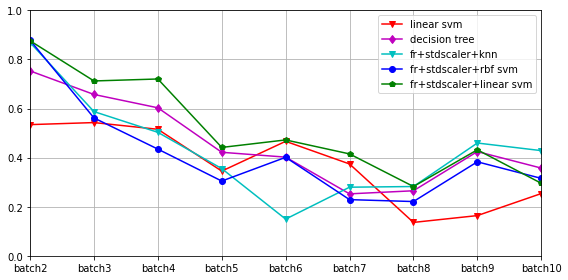

In [ ]:
plt.figure(figsize=(8,4))    
for idx in range(res.shape[0]):
    plt.plot(np.arange(res.shape[1]),res[idx,:],methods[idx][2],label=methods[idx][0])
plt.xticks(np.arange(0,res.shape[1]),['batch{}'.format(idx+1) for idx in test_batch])
plt.grid(True)
plt.xlim(0,res.shape[1]-1)
plt.ylim(0,1)
plt.legend()    
plt.tight_layout()
plt.show()

利用第五章教的Neural Network來構建四個前饋神經網絡(FNN)。在前饋神經網絡中，兩個相鄰層是完全連接的。四個FNN 的神經架構如下：

128->BN->512-512->Dropout(0.1)->6

128->128->128->128->6

128->BN->512->128->64->6

128->32->32->32->32->Dropout(0.1)->6

其中第一個數字表示輸入向量的維數，最後一個數字表示輸出單元的數量，另一個數字表示隱藏層的單元數，BN 表示批量歸一化層，Dropout(0.1) 表示 dropout層，dropout ratio 設置為 0.1。隱藏單元的激活函數是relu，輸出單元的激活函數是softmax。損失函數是sparse categorical cross entropy ，優化器是 adam。

In [ ]:
train_batch=[0]
test_batch =[x  for x in range(len(dataset)) if x not in train_batch]
data       = np.vstack([dataset[x][['f{}'.format(idx) for idx in range(128)]].values.copy() for x in train_batch])
target     = np.hstack([dataset[x]['label'].values.copy().ravel()  for x in train_batch])
res = np.zeros((5,len(test_batch)))

In [ ]:
import tensorflow as tf
import numpy as np

def def_model1():
    model  = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(128,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(512,activation='relu'))
    model.add(tf.keras.layers.Dense(512,activation='relu'))
    model.add(tf.keras.layers.Dropout(0.1))
    model.add(tf.keras.layers.Dense(6,activation='softmax'))
    model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    return model

def def_model2():
    model  = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(128,)))
    model.add(tf.keras.layers.Dense(128,activation='relu'))
    model.add(tf.keras.layers.Dense(128,activation='relu'))
    model.add(tf.keras.layers.Dense(128,activation='relu'))
    model.add(tf.keras.layers.Dense(6,activation='softmax'))
    model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    return model

def def_model3():
    model  = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(128,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(512,activation='relu'))
    model.add(tf.keras.layers.Dense(128,activation='relu'))
    model.add(tf.keras.layers.Dense(64,activation='relu'))
    model.add(tf.keras.layers.Dense(6,activation='softmax'))
    model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    return model
    
def def_model4():
    model  = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(128,)))
    model.add(tf.keras.layers.Dense(32,activation='relu'))
    model.add(tf.keras.layers.Dense(32,activation='relu'))
    model.add(tf.keras.layers.Dense(32,activation='relu'))
    model.add(tf.keras.layers.Dense(32,activation='relu'))
    model.add(tf.keras.layers.Dropout(0.1))
    model.add(tf.keras.layers.Dense(6,activation='softmax'))
    model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    return model
    
###
markers      = ['bo-','gp-','cv-','m*-']
create_model = [def_model1, def_model2, def_model3, def_model4]

res_models = np.zeros((len(create_model),len(test_batch)))
trials     = 10

cdata = data.copy()
for trial in range(trials):
    models = [None]*len(create_model)    
    for i, def_model in enumerate(create_model):
        models[i] = def_model()
            
    np.random.seed(trial)
    for i in range(len(models)):
        if models[i] is not None:
            models[i].fit(cdata,target,batch_size=32,epochs=100,validation_split=0.1)

    for res_id,idx in enumerate(test_batch):
        test_data  = dataset[idx][['f{}'.format(i) for i in range(128)]].values
        test_target= dataset[idx]['label'].values
        for i in range(len(models)):
            if models[i] is not None:
                r = models[i].evaluate(test_data,test_target)
                res_models[i,res_id]+= r[1]
res_models/=trials

串流輸出內容已截斷至最後 5000 行。
13/13 [==============================] - 0s 6ms/step - loss: 0.1701 - accuracy: 0.9425 - val_loss: 0.3466 - val_accuracy: 0.8444
Epoch 10/100
13/13 [==============================] - 0s 7ms/step - loss: 0.1406 - accuracy: 0.9525 - val_loss: 0.0947 - val_accuracy: 1.0000
Epoch 11/100
13/13 [==============================] - 0s 8ms/step - loss: 0.1176 - accuracy: 0.9525 - val_loss: 0.3492 - val_accuracy: 0.8667
Epoch 12/100
13/13 [==============================] - 0s 7ms/step - loss: 0.1555 - accuracy: 0.9400 - val_loss: 0.1775 - val_accuracy: 0.9778
Epoch 13/100
13/13 [==============================] - 0s 6ms/step - loss: 0.1583 - accuracy: 0.9525 - val_loss: 0.0907 - val_accuracy: 0.9778
Epoch 14/100
13/13 [==============================] - 0s 6ms/step - loss: 0.2179 - accuracy: 0.9200 - val_loss: 0.0619 - val_accuracy: 1.0000
Epoch 15/100
13/13 [==============================] - 0s 7ms/step - loss: 0.1249 - accuracy: 0.9475 - val_loss: 0.1565 - val_accuracy: 1.000

結果可視化

可以看出model2的訓練結果並不好，所以各層神經網路的配置還是很重要的。

而model4的準確度看起來也是偏低，推測是由於128->32的過程中捨去了太多的線索導致的。

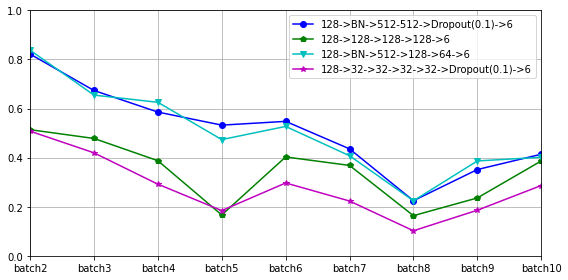

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))    
for i  in range(len(create_model)):
    plt.plot(np.arange(res_models.shape[1]),res_models[i,:],markers[i])
plt.xticks(np.arange(0,res.shape[1]),['batch{}'.format(idx+1) for idx in test_batch])
plt.grid(True)
plt.xlim(0,res_models.shape[1]-1)
plt.ylim(0,1)
plt.legend(['{}'.format(m) for m in ['128->BN->512-512->Dropout(0.1)->6',
                                        '128->128->128->128->6',
                                        '128->BN->512->128->64->6',
                                        '128->32->32->32->32->Dropout(0.1)->6']])    
plt.tight_layout()
plt.show()

#使用自定義模型myGaussianClassifier
利用第三章貝氏分類器做出高斯分類器，假設P(X|C=i),∀iP(X|C=i),∀i呈現高斯分佈N(μi,Σi)，看一下高斯分類器的分類能力如何。

In [ ]:
from numpy.ma.core import exp
import numpy as np
import sklearn.datasets as ds
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.stats import multivariate_normal
from sklearn.metrics import accuracy_score

class myGaussianClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self,alpha=1.e-5):
        if isinstance(self,myGaussianClassifier):
            super(myGaussianClassifier,self).__init__()  
        self.alpha = alpha

    def fit(self,train,target):   
        N,d = train.shape
        label = np.sort(np.unique(target.ravel()))
        self.c_     = label.size
        self.d_     = d
        self.prior_ = np.zeros((self.c_,))
        self.mean_  = np.zeros((self.c_,self.d_))
        self.cov_   = np.zeros((self.c_,self.d_,self.d_))
        # 計算 mean, covariance
        for cid,y in enumerate(label):
            idx = np.nonzero(target.ravel()==y)
            self.cov_[cid] = np.cov(train[idx],rowvar=False)+self.alpha*np.eye(d)
            self.mean_[cid] = np.average(train[target==cid],axis=0)
            self.prior_[cid] = np.sum(target.ravel()==cid)/target.size
        self.P0_ = multivariate_normal(self.mean_[0],self.cov_[0],allow_singular=True)
        self.P1_ = multivariate_normal(self.mean_[1],self.cov_[1],allow_singular=True)
        return self

    def predict(self,X, y=None):
        preds = []
        for x in X:
          if self.P0_.pdf(x)*self.prior_[0]>self.P1_.pdf(x)*self.prior_[1]:
            preds.append(0)
          else:
            preds.append(1)
        return preds

    def predict_proba(self,X, y=None):
        preds = []
        for x in X:
          zo = []
          zo.append(self.P0_.pdf(x)*self.prior_[0])
          zo.append(self.P1_.pdf(x)*self.prior_[1])
          preds.append(zo)
        return preds

    def score(self,X,y):
        pX = self.predict(X)
        return accuracy_score(pX,y)

In [ ]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)

# defining classifiers: knn, svm_rbf, svm_linear, svm_linear0, dt
my_Gauss = myGaussianClassifier()

# input model
methods=[('Gaussian Classifier',my_Gauss,'rv-')]

# prepare the training and test sets
train_batch=[0]
test_batch =[x  for x in range(len(dataset)) if x not in train_batch]
data       = np.vstack([dataset[x][['f{}'.format(idx) for idx in range(128)]].values.copy() for x in train_batch])
target     = np.hstack([dataset[x]['label'].values.copy().ravel()  for x in train_batch])

res = np.zeros((len(methods),len(test_batch)))

# the experiment for each method is performed 10 times.
total_round = 10
for trial in range(total_round):
    print('trial {}'.format(trial))
    for p in methods:
        print('train {}'.format(p[0]))
        np.random.seed(trial)
        cdata = data.copy()
        with parallel_backend('loky'):
            p[1].fit(cdata,target)

    for res_id,idx in enumerate(test_batch):
        test_data  = dataset[idx][['f{}'.format(i) for i in range(128)]].values
        test_target= dataset[idx]['label'].values
        for i in range(len(methods)):
            res[i,res_id]+=methods[i][1].score(test_data,test_target)
res/=total_round

trial 0
train Gaussian Classifier
trial 1
train Gaussian Classifier
trial 2
train Gaussian Classifier
trial 3
train Gaussian Classifier
trial 4
train Gaussian Classifier
trial 5
train Gaussian Classifier
trial 6
train Gaussian Classifier
trial 7
train Gaussian Classifier
trial 8
train Gaussian Classifier
trial 9
train Gaussian Classifier


可以看出高斯分類器由於模型過於簡單，對於複雜的問題效果很差。

10~30%的準確度和用猜的差不多(1/6=0.166)

In [ ]:
print(my_Gauss.score(data,target))

0.42247191011235957


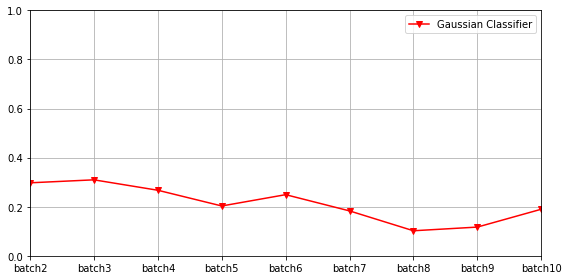

In [ ]:
plt.figure(figsize=(8,4))    
for idx in range(res.shape[0]):
    plt.plot(np.arange(res.shape[1]),res[idx,:],methods[idx][2],label=methods[idx][0])
plt.xticks(np.arange(0,res.shape[1]),['batch{}'.format(idx+1) for idx in test_batch])
plt.grid(True)
plt.xlim(0,res.shape[1]-1)
plt.ylim(0,1)
plt.legend()    
plt.tight_layout()
plt.show()

#判斷模型相似度
這裡使用看起來訓練效果最好的fr+stdscaler+linear svm來當作基準(不比較FNN是由於該系列不支援cross_val_score)

根據第三章教到的顯著水準(significance level)來定義:

以paired t-test顯著程度0.05前提下，平均準確率最高那個分類器與另外6個分類器，判斷在平均準確率上是否有顯著差異.

In [ ]:
methods=[('linear svm',svm_linear0),
         ('decision tree',dt),
         ('fr+stdscaler+knn',knn),
         ('fr+stdscaler+rbf svm',svm_rbf),
         ('fr+stdscaler+linear svm',svm_linear),
          ('Gaussian Classifier',my_Gauss)     
    ]

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn import neighbors, svm, naive_bayes 
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
import sklearn.datasets as ds
import numpy as np
from scipy import stats

methods_score = []
for i in methods:
  methods_score.append(cross_val_score(i[1], data, target, scoring='accuracy',cv = kfold, verbose=10))


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] START .....................................................................
[CV] END ................................ score: (test=0.989) total time=   5.0s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.0s remaining:    0.0s


[CV] END ................................ score: (test=0.989) total time=   3.3s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.3s remaining:    0.0s


[CV] END ................................ score: (test=1.000) total time=  17.7s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   26.0s remaining:    0.0s


[CV] END ................................ score: (test=0.966) total time=  17.2s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   43.2s remaining:    0.0s


[CV] END ................................ score: (test=1.000) total time=  12.9s
[CV] START .....................................................................
[CV] END ................................ score: (test=0.955) total time=   0.0s
[CV] START .....................................................................
[CV] END ................................ score: (test=0.955) total time=   0.0s
[CV] START .....................................................................
[CV] END ................................ score: (test=0.978) total time=   0.0s
[CV] START .....................................................................
[CV] END ................................ score: (test=0.944) total time=   0.0s
[CV] START .....................................................................
[CV] END ................................ score: (test=0.955) total time=   0.0s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   56.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   56.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.989) total time=  11.3s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.3s remaining:    0.0s


[CV] END ................................ score: (test=0.955) total time=  10.9s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   22.2s remaining:    0.0s


[CV] END ................................ score: (test=0.978) total time=  10.9s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   33.1s remaining:    0.0s


[CV] END ................................ score: (test=0.966) total time=  11.6s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   44.7s remaining:    0.0s


[CV] END ................................ score: (test=0.989) total time=  11.1s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   55.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   55.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.989) total time= 1.2min
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s


[CV] END ................................ score: (test=0.978) total time= 1.1min
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.3min remaining:    0.0s


[CV] END ................................ score: (test=1.000) total time= 1.1min
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.5min remaining:    0.0s


[CV] END ................................ score: (test=0.955) total time= 1.1min
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  4.6min remaining:    0.0s


[CV] END ................................ score: (test=0.989) total time= 1.2min
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.989) total time=  32.9s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   32.9s remaining:    0.0s


[CV] END ................................ score: (test=0.955) total time=  33.3s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s


[CV] END ................................ score: (test=1.000) total time=  33.0s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.7min remaining:    0.0s


[CV] END ................................ score: (test=0.944) total time=  33.1s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  2.2min remaining:    0.0s


[CV] END ................................ score: (test=0.989) total time=  33.0s
[CV] START .....................................................................
[CV] END ................................ score: (test=0.416) total time=   0.0s
[CV] START .....................................................................
[CV] END ................................ score: (test=0.416) total time=   0.0s
[CV] START .....................................................................
[CV] END ................................ score: (test=0.427) total time=   0.0s
[CV] START .....................................................................
[CV] END ................................ score: (test=0.393) total time=   0.0s
[CV] START .....................................................................
[CV] END ................................ score: (test=0.416) total time=   0.0s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished


TypeError: ignored

可以看到一個很有趣的結果，居然只有Gaussian Classifier不具有顯著差異，如果只從前面幾個的數據來判斷，和fr+stdscaler+linear svm最像的分類器應該是decision tree，實際上前面5個分類器的結果也和前面的實驗吻合，但前面的實驗忽略了一個很重要的數據:batch 1 本身的訓練成果，我認為這可能是主要原因之一。

In [ ]:
for i in range(len(methods_score)):
  method_t,method_pvalue = stats. ttest_1samp (methods_score[4]-methods_score[i],0)
  print("{} pvalue = {}".format(methods[i][0],method_pvalue))

linear svm pvalue = 0.10870095132492331
decision tree pvalue = 0.0777416409478997
fr+stdscaler+knn pvalue = 1.0
fr+stdscaler+rbf svm pvalue = 0.20799999999999935
fr+stdscaler+linear svm pvalue = nan
Gaussian Classifier pvalue = 1.5343629751998116e-07


結論:

可以看出當問題較為複雜時，linear svm原本的分類能力較弱一點，但是透過第九章教的集群(CLUSTERING)來做資料前處理可以顯著的提升準確度。

對於多層神經網路，每層的配置很重要，不可以太早下降太多維度，並且輸入->BN->高維->低維->輸出對於此問題是不錯的選擇。

而專題本身研究的問題在機器學習的課程中較少被提到(一般會假設資料集是正確的)，資料集的取得也較為不容易，因此沒有再另外使用自己產生的資料集來做研究。
